In [19]:
### Librerias ###

# data drawing
import pandas as pd
import numpy as np
import os
from datetime import datetime
from functools import reduce # para hacer un one hot merge

# visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# API
import requests

# RFM - Model

# Pre - procesing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Modeling
from sklearn.cluster import KMeans


# Validation
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings("ignore")


# **Data Load**

In [20]:
payment = pd.read_csv('payment.csv')

In [21]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30000 non-null  int64  
 1   id_solicitud  30000 non-null  object 
 2   fecha         30000 non-null  object 
 3   user_id       30000 non-null  int64  
 4   monto         30000 non-null  float64
 5   tipo_resulto  30000 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.4+ MB


In [22]:
payment.head(10)

,id,id_solicitud,fecha,user_id,monto,tipo_resulto
0,1,9c7fa26c-1717-4346-ab68-a0a029d6149f,2024-04-07 04:04:45.578389,1225,5617.81,rejected_payment_result
1,2,aa756085-fd88-4c35-935c-c1e109d44919,2023-12-17 05:40:50.650120,9099,859.84,collected_payment_result
2,3,339a3c73-dafb-48a3-866b-5c013bd151ac,2024-09-30 14:49:40.724287,9979,5703.18,collected_payment_result
3,4,61f4fd09-5432-4761-8e3e-7fdf91a2593a,2024-03-19 10:18:29.839453,609,6876.47,rejected_payment_result
4,5,0810310e-c49a-440f-b6d6-559e12d74e9d,2023-10-11 13:15:40.540756,2950,5815.67,collected_payment_result
5,6,9f351eb0-f617-4917-8ce2-d70300874b4d,2024-03-23 16:10:48.065099,5328,5050.08,rejected_payment_result
6,7,98565cfd-1221-4613-86ec-688c2c2c76a0,2024-03-09 02:05:23.573364,3348,4570.20,collected_payment_result
7,8,394b2419-2e8b-413e-bb08-cfe86278aa19,2024-05-20 03:18:11.393948,4213,9727.33,collected_payment_result
8,9,1a6f8f2e-6f10-4f79-8cd3-cd33b50dddd0,2023-11-25 23:39:27.511778,1007,876.55,collected_payment_result
9,10,6d5fa85b-4ca2-472c-a428-a74a0a94da59,2024-08-31 16:17:11.069064,4819,3459.28,collected_payment_result


# **EDA**

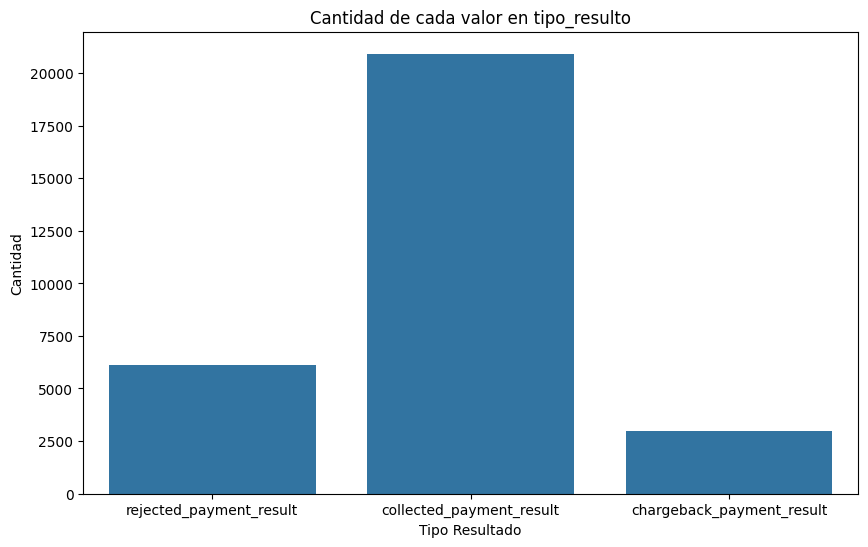

In [23]:
#Payment

# Creo grafico de barras para payments por tipo_resulto
plt.figure(figsize=(10,6))
sns.countplot(x='tipo_resulto', data=payment)

# Añadir títulos y etiquetas
plt.title('Cantidad de cada valor en tipo_resulto')
plt.xlabel('Tipo Resultado')
plt.ylabel('Cantidad')

# Mostrar el gráfico
plt.show()

# **Analisis RFM**

In [54]:
# Realizo un analisis de RFM sobre payments para trx aprobadas
payment_aprob = payment[payment['tipo_resulto'] == 'collected_payment_result']
#payment_aprob.set_index('user_id', inplace=True)
#payment_aprob.drop(columns=['id_solicitud','tipo_resulto','id'],inplace=True)

In [55]:
## RECENCY ##
# Recency es una métrica que indica cuánto tiempo ha pasado desde la última fecha de cobro

# Convertir 'fecha' a datetime (si no lo está)
payment_aprob['fecha'] = pd.to_datetime(payment_aprob['fecha'], errors='coerce')

# Obtener la fecha actual
current_date = datetime.now()

# Calcular la recency
payment_aprob['recency'] = (current_date - payment_aprob['fecha']).dt.days

# Calcular el promedio de recency por user_id
average_recency_df = payment_aprob.groupby('user_id')['recency'].mean().reset_index()

# Renombrar la columna para mayor claridad
average_recency_df.columns = ['user_id', 'average_recency']


In [56]:
## FRECUENCY
# es una métrica que indica cuántas veces un usuario ha interactuado realizando cobros

# Calcular la frecuencia de transacciones por 'user_id'
frequency_df = payment['user_id'].value_counts().reset_index()

# Renombrar las columnas para mayor claridad
frequency_df.columns = ['user_id', 'frecuency']



In [57]:
## MONETARY

# Uso API de argentinadatos para pasar todo a usd

# URL base de la API
BASE_URL = 'https://api.argentinadatos.com/v1/cotizaciones/dolares'

# Realizar una solicitud a la API
response = requests.get(BASE_URL)

# Verificar que la solicitud fue exitosa
if response.status_code == 200:
    data = response.json()

    # Convertir los datos en un DataFrame de pandas
    df = pd.DataFrame(data)

else:
    print(f"Error en la solicitud: {response.status_code}")

# Tomo solo dolar bolsa (mep)
df['fecha'] = pd.to_datetime(df['fecha'])
df_dolar = df[(df['casa'] == "bolsa")]

In [58]:
# Convertir 'fecha' a datetime en payment_aprob
payment_aprob['fecha'] = payment_aprob['fecha'].dt.strftime('%Y-%m-%d')
payment_aprob['fecha'] = pd.to_datetime(payment_aprob['fecha'], errors='coerce')

# Convertir 'fecha' a datetime en df_dolar (si no lo está)
df_dolar['fecha'] = pd.to_datetime(df_dolar['fecha'], errors='coerce')

# Ahora realizar el merge
payment_aprob = payment_aprob.merge(df_dolar, on='fecha', how='left')

# Calculo el monto en dolares usando dolar bolsa venta
payment_aprob['monto_dolares'] = payment_aprob['monto'] / payment_aprob['compra']

# Agrupar por user_id y sumar monto_dolares
monetary_df = payment_aprob.groupby('user_id')['monto_dolares'].sum().reset_index()

# Renombrar la columna para mayor claridad
monetary_df.columns = ['user_id', 'total_monto_dolares']




In [59]:
# Armo dataframe final para RFM
dataframes = [monetary_df,frequency_df,average_recency_df]

# Función para realizar el merge
def merge_dataframes(left, right):
    return pd.merge(left, right, on='user_id', how='left')

# Realizar merge de todos los DataFrames en la lista
rfm = reduce(merge_dataframes, dataframes)

In [60]:
# Termino de pulir rfm dataframe
rfm.fillna(0, inplace=True)
rfm.set_index('user_id', inplace=True)
rfm_final = rfm[
    (rfm['average_recency'] > 0) &
    (rfm['frecuency'] > 0) &
    (rfm['total_monto_dolares'] > 0)
]

In [61]:
### ENTRENO MODELO DE CLUSTER K-MEANS ###
# armamos la matriz de características
X = rfm_final.copy()

# Separamos en dataset de train y test
X_train, X_test = train_test_split(X, test_size=0.3, random_state=12)

# Estandarizamos la matriz de features (uso estándar) para que cada variable tenga media 0 y desviación estándar 1.
# Esto es importante porque muchos modelos, especialmente aquellos basados en distancias (como KNN o SVM) son sensibles a la escala de las variables
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)


# Definimos el modelo base
kmeans = KMeans(random_state=13)


# Definimos la grilla de hiperparámetros a evaluar
param_grid = {'n_clusters': list(range(3, 5)), 'init': ['k-means++', 'random']}

# Configuramos la búsqueda en grilla con validación cruzada
grid_search_kmeans = GridSearchCV(
    estimator=kmeans,
    param_grid=param_grid,
    cv=KFold(n_splits=10, shuffle=True, random_state=13),
    n_jobs=-1
)

# Entrenamos el modelo con los datos estandarizados
grid_kmeans_scale = grid_search_kmeans.fit(X_train_scaler)


# Predicción de clusters en el conjunto de test
clusters_scaler = grid_kmeans_scale.predict(X_test_scaler)


print("Mejor número de clusters con StandardScaler:", grid_kmeans_scale.best_params_['n_clusters'])



Mejor número de clusters con StandardScaler: 4


In [62]:
# Función para evaluar y retornar métricas del modelo de clustering
def evaluar_clustering(X_test, clusters_test, modelo):
    return {
        'inertia': modelo.inertia_,
        'silhouette_test': silhouette_score(X_test, clusters_test),
        'calinski_harabasz_test': calinski_harabasz_score(X_test, clusters_test),
        'davies_bouldin_test': davies_bouldin_score(X_test, clusters_test),
    }

# Obtenemos las predicciones de clusters
clusters_test = grid_kmeans_scale.best_estimator_.predict(X_test_scaler)

# Calculamos las métricas
metricas = evaluar_clustering(X_test_scaler, clusters_test, grid_kmeans_scale.best_estimator_)

# Mostramos las métricas
print("Métricas del modelo entrenado con StandardScaler:")
for nombre, valor in metricas.items():
    print(f"{nombre}: {valor:.4f}")



Métricas del modelo entrenado con StandardScaler:
inertia: 6581.4933
silhouette_test: 0.2900
calinski_harabasz_test: 1517.7574
davies_bouldin_test: 1.1119


silhouette mientras más cercano a 1 mejor estarán armados los clusters. En este caso el modelo no es tan bueno.

In [63]:
# Aplico el modelo
X_scale = scaler.fit_transform(X)  

# Predecir los clusters para cada registro en X
clusters = grid_kmeans_scale.predict(X_scale)


# Añadir la columna de clusters a tu DataFrame original
rfm_final['cluster'] = clusters

In [64]:
# Calcular la media por cada cluster para cada variable
medias_por_cluster = rfm_final.groupby('cluster').mean()

print("Medias por cluster:")
print(medias_por_cluster)

Medias por cluster:
         total_monto_dolares  frecuency  average_recency
cluster                                                 
0                  12.849400   3.951630       395.469506
1                   5.672884   2.173763       318.688638
2                  23.984391   5.709970       414.403251
3                   7.060233   2.210205       488.087404


# Análisis por Cluster

**Cluster 0**:

total_monto_dolares: 23.98 (promedio de compras en dólares).

frecuency: 5.71 (promedio de compras realizadas).

average_recency: 414.39 (promedio de días desde la última compra).

Interpretación: Este clúster tiene clientes que gastan en promedio más dinero por compra (casi 24 dólares), realizan compras con buena frecuencia (alrededor de 5.7 compras) y su recencia promedio es bastante alta (más de 400 días desde su última compra). Esto sugiere que aunque estos clientes compran con cierta frecuencia, hace tiempo que no compran, lo que podría indicar clientes que necesitan ser reactivados o que no están realizando compras recientes pero aún generan ingresos considerables cuando lo hacen.

**Cluster 1**:

total_monto_dolares: 5.68 (promedio de compras en dólares).

frecuency: 2.17 (promedio de compras realizadas).

average_recency: 318.66 (promedio de días desde la última compra).

Interpretación: Este grupo está formado por clientes que gastan poco dinero (menos de 6 dólares de promedio por compra), compran pocas veces (alrededor de 2 compras) y su recencia promedio es 318.66 días. Esto indica que estos clientes no compran frecuentemente, y sus compras son relativamente pequeñas. Este clúster podría estar compuesto por clientes ocasionales o de bajo valor, que hacen compras esporádicas.

**Cluster 2**:

total_monto_dolares: 12.85 (promedio de compras en dólares).

frecuency: 3.95 (promedio de compras realizadas).

average_recency: 395.51 (promedio de días desde la última compra).

Interpretación: Este grupo tiene clientes que gastan un promedio medio por compra (alrededor de 12.85 dólares) y realizan compras con una frecuencia moderada (casi 4 compras). Su recencia promedio (casi 396 días) indica que, aunque compran un número razonable de veces, su última compra fue hace bastante tiempo. Estos clientes podrían ser más valiosos que los del clúster 1, pero también necesitan atención para mejorar la recencia de sus compras.

**Cluster 3**:

total_monto_dolares: 7.06 (promedio de compras en dólares).

frecuency: 2.21 (promedio de compras realizadas).

average_recency: 488.03 (promedio de días desde la última compra).

Interpretación: Este clúster tiene clientes que gastan poco dinero por compra (alrededor de 7.06 dólares) y realizan muy pocas compras (cerca de 2 compras). La recencia promedio es bastante alta (más de 488 días), lo que indica que estos clientes no compran desde hace mucho tiempo. Este grupo podría estar compuesto por clientes inactivos o de bajo valor.

# Conclusiones
Los clústeres 0 y 2 parecen representar a los clientes de mayor valor o más activos, aunque en el caso de 0 presenta una alta recencia.

Los clústeres 1 y 3 representan clientes menos comprometidos, con una menor frecuencia de compra y un gasto reducido. El clúster 3 tiene una recencia aún más alta, lo que indica que estos clientes están bastante inactivos.

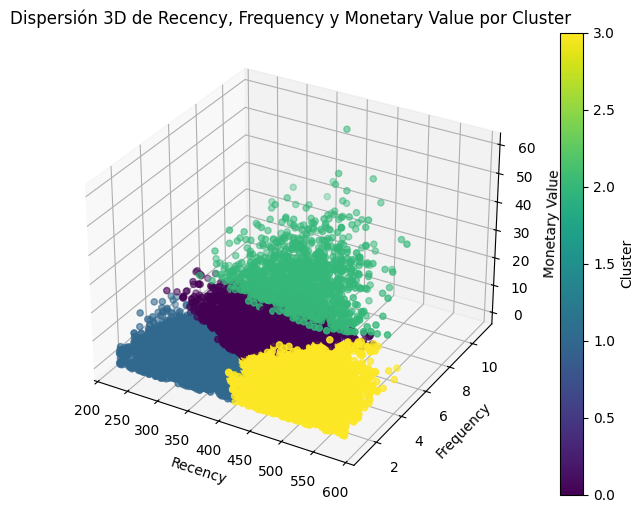

In [67]:

# Configurar el gráfico 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Crear el gráfico 3D
sc = ax.scatter(rfm_final['average_recency'], rfm_final['frecuency'], rfm_final['total_monto_dolares'], c=rfm_final['cluster'], cmap='viridis')

# Etiquetas y título
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')
plt.title('Dispersión 3D de Recency, Frequency y Monetary Value por Cluster')

# Añadir leyenda
plt.colorbar(sc, label='Cluster')
plt.show()